## Abstract

@Rijal2025 recently applied attention mechanisms to the problem of mapping genotype to phenotype. We noted their architecture omitted standard Transformer components, prompting us to test if including these elements could enhance performance on their multi-environment yeast dataset. Our analysis revealed that incorporating standard Transformer elements substantially improves predictive accuracy for this task.

----

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on AirTable, SlackBot will message you an AI disclosure that you should place here.
:::

## Introduction

The recent preprint by @Rijal2025 introduces an application of attention mechanisms for inferring genotype-phenotype maps, particularly focusing on capturing complex epistatic interactions. They showed that their attention-based model outperformed linear and linear + pairwise models. Overall, their work sparked considerable interest and discussion within our journal club.

While appreciating the novelty of applying attention in this domain, we noted that the specific architecture employed is relatively minimal. It utilizes stacked attention layers but omits several components commonly found in the original transformer model [@Vaswani2017], such as skip connections, layer normalization, or feed-forward blocks. We found these omissions interesting, since the transformer was the first architecture to fully leverage the power of attention mechanisms, and did so to great success in many distinct domains.

This led us to a very straightforward inquiry: Could the performance of the attention-based genotype-phenotype model proposed by @Rijal2025 be improved by replacing it with a standard transformer architecture?"

## The dataset

The experimental data used in @Rijal2025 comes from the work of @Ba2022, who performed a large-scale quantitative trait locus (QTL) study in yeast. In short, they measured the growth rates of ~100,000 yeast segregants across 18 conditions and for ~40,000 loci, creating a massive dataset suitable for mapping genotype to phenotype.

Due to extensive linkage disequilibrium (LD), the loci in the dataset are highly correlated with each other. To create a set of independent loci, @Rijal2025 a defined a set of loci such that the correlation between the SNPs present at any pair of loci is less than 94%, resulting in a set of 1164 "independent" loci.

Unfortunately, they didn't provide this set of loci, nor the genotypic and phenotypic data used for training, so we located the [raw data](https://datadryad.org/dataset/doi:10.5061/dryad.1rn8pk0vd) that @Ba2022 originally uploaded alongside their study, then used [this notebook](https://github.com/Emergent-Behaviors-in-Biology/GenoPhenoMapAttention/blob/main/obtain_independent_loci.ipynb) uploaded by @Rijal2025 to recapitulate the 1164 loci. To save everyone else the trouble, we uploaded the train, test, and validation datasets we're *pretty sure* @Rijal2025 used in their study.

You can find the data here:

```
s3://2025-attention-is-almost-all-you-need/datasets
```

We'll use this data in what follows, so let's go ahead and download it into the current working directory:

In [1]:
import subprocess
from pathlib import Path

dataset_dir = Path("datasets/")
remote_dir = "s3://2025-attention-is-almost-all-you-need/datasets/"

subprocess.run(f"aws s3 sync {remote_dir} {dataset_dir}".split(" "))

CompletedProcess(args=['aws', 's3', 'sync', 's3://2025-attention-is-almost-all-you-need/datasets/', 'datasets'], returncode=0)

In [2]:
# | echo: false
# | column: margin
# | tbl-cap: Table 1. The scraped test dataset $R^2$ values for the attention model in Figure 3 of @Rijal2025. Determined by manual pixel counting.
import pandas as pd
from analysis.dataset import phenotype_names

scores = [
    0.612,
    0.621,
    0.632,
    0.609,
    0.615,
    0.582,
    0.566,
    0.610,
    0.638,
    0.487,
    0.604,
    0.566,
    0.630,
    0.600,
    0.618,
    0.653,
    0.630,
    0.609,
]

fig3_results = pd.DataFrame(
    {
        "phenotype": phenotype_names,
        "source R2": scores,
    }
)
fig3_results

,phenotype,source R2
0,23C,0.612
1,25C,0.621
2,27C,0.632
3,30C,0.609
4,33C,0.615
5,35C,0.582
6,37C,0.566
7,cu,0.610
8,suloc,0.638
9,ynb,0.487


## Reproducing the single environment model results

To be sure we correctly reverse-engineered the specifics of their training/validation/test datasets and accurately re-implemented their model, let's try and reproduce the attention model performance seen in Figure 3 (red dots):

![Figure 3 from @Rijal2025. Original caption: "*Comparison of model performance in yeast QTL mapping data. We show R2 on test datasets for linear, linear+pairwise, and attention-based model (with d = 12) across 18 phenotypes (relative growth rates in various environments). For the linear + pairwise mode, the causal loci inferred by @Ba2022 are used.*"](assets/fig3.jpg){fig-align="center" width=70% fig-alt="Figure 3 from @Rijal2025 showing the single-environment model performances."}

To do this, we need to create configuration objects that specify the model architecture and how the training should proceed. These can be specified via two configuration objects, `ModelConfig` and `TrainConfig`. Here we define them to match the design of the experiment that produced Figure 3:

In [3]:
from analysis.base import ModelConfig, TrainConfig

model_config = ModelConfig(
    model_type="rijal_et_al",
    seq_length=1164,
    embedding_dim=13,
    num_layers=3,
)

train_template_config = TrainConfig(
    data_dir=dataset_dir,
    save_dir=Path("models/fig3"),
    name_prefix="fig3_23C",
    phenotypes=["23C"],
    optimizer="adam",
    batch_size=64,
    learning_rate=0.001,
    lr_schedule=False,
    weight_decay=0.0,
    max_epochs=200,
    gradient_clip_val=0,
    use_cache=True,
    use_modal=True,
)

As you may have noticed, this train config is specific to the phenotype, `23C`. Since we're going to train a model for each phenotype, let's create a `train_config` (and `model_config`) for each phenotype, using the above train_config as a template.

In [4]:
import attrs
from analysis.dataset import phenotype_names

jobs = []
for phenotype in phenotype_names:
    phenotype_config = attrs.evolve(
        train_template_config, phenotypes=[phenotype], name_prefix=f"fig3_{phenotype}"
    )
    jobs.append((model_config, phenotype_config))

With each job properly configured, we can train a model for each phenotype:

In [5]:
from analysis.train import run_trainings

model_dirs = run_trainings(jobs)

Pre-trained model 'fig3_23C' found. Returning path.
Pre-trained model 'fig3_25C' found. Returning path.
Pre-trained model 'fig3_27C' found. Returning path.
Pre-trained model 'fig3_30C' found. Returning path.
Pre-trained model 'fig3_33C' found. Returning path.
Pre-trained model 'fig3_35C' found. Returning path.
Pre-trained model 'fig3_37C' found. Returning path.
Pre-trained model 'fig3_cu' found. Returning path.
Pre-trained model 'fig3_suloc' found. Returning path.
Pre-trained model 'fig3_ynb' found. Returning path.
Pre-trained model 'fig3_eth' found. Returning path.
Pre-trained model 'fig3_gu' found. Returning path.
Pre-trained model 'fig3_li' found. Returning path.
Pre-trained model 'fig3_mann' found. Returning path.
Pre-trained model 'fig3_mol' found. Returning path.
Pre-trained model 'fig3_raff' found. Returning path.
Pre-trained model 'fig3_sds' found. Returning path.
Pre-trained model 'fig3_4NQO' found. Returning path.


::: {.callout-important appearance="simple"}
# A note about training behavior
The above code will initiate training for all configured jobs, with important considerations:

* Caching: Since `train_config.use_cache = True` and these models are stored in the GitHub repository, executing this locally will use cached models instead of performing expensive retraining
* Training Duration: Each training job takes approximately 2.5 hours to complete on an A10G GPU, so running all jobs without caching would require significant time
* Compute Configuration: In our production environment, we set `train_config.use_modal = True` to distribute compute jobs via [Modal](https://modal.com/). For compatibility with different compute architectures, this notebook uses `train_config.use_modal = False` by default.
:::

Inside each run directory is a `metrics.csv` that we can get the test dataset $R^2$ from and compare directly against Figure 3.

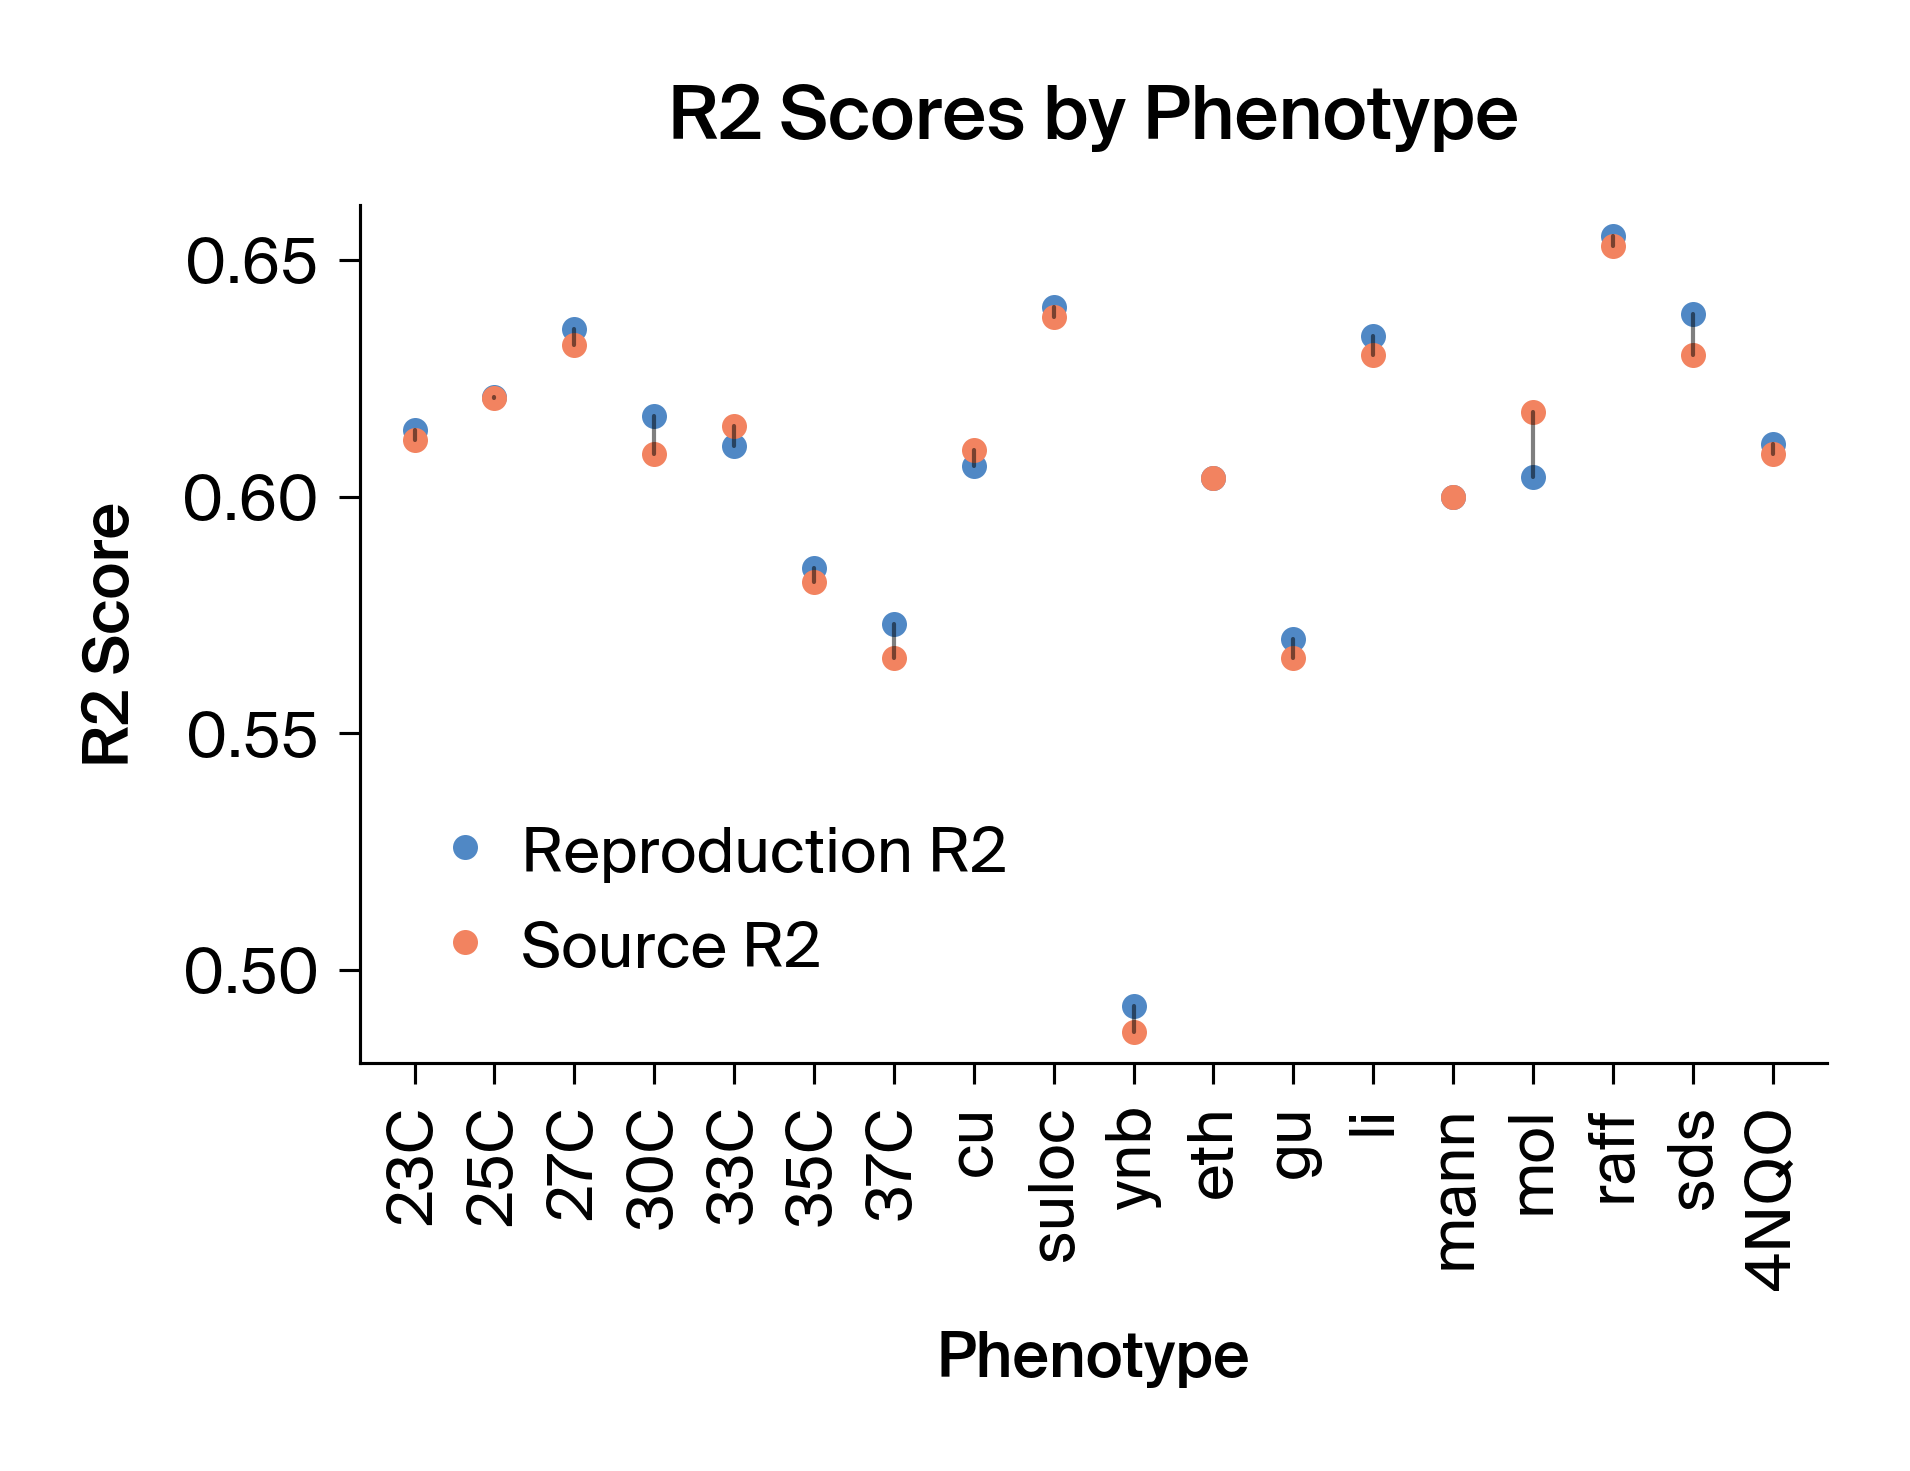

In [6]:
# | code-fold: true
# | label: fig-reproduction
# | fig-cap: Comparison of test dataset $R^2$ values between @Rijal2025 and our re-implementation.
import arcadia_pycolor as apc
import matplotlib.pyplot as plt

apc.mpl.setup()


def get_test_r2(model_dir: Path) -> float:
    metrics = pd.read_csv(model_dir / "metrics.csv")
    return float(metrics.loc[metrics["metric"] == "test_r2", "value"].iloc[0])


fig3_reproduction_r2 = []
for model_dir in model_dirs:
    fig3_reproduction_r2.append(get_test_r2(model_dir))

fig3_results["reproduction R2"] = fig3_reproduction_r2

df = pd.DataFrame(fig3_results)
plt.figure(dpi=300)
for x, y1, y2 in zip(df["phenotype"], df["source R2"], df["reproduction R2"], strict=True):
    plt.plot(
        [x, x],
        [y1, y2],
        color="black",
        linewidth=1,
        alpha=0.5,
    )
plt.scatter(df["phenotype"], df["reproduction R2"], label="Reproduction R2")
plt.scatter(df["phenotype"], df["source R2"], label="Source R2")
plt.xlabel("Phenotype")
plt.ylabel("R2 Score")
plt.title("R2 Scores by Phenotype")
plt.legend(loc=(0.05, 0.1))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

With an $n$ of 1, it's difficult to say for certain how well we've reproduced the results. However, even for the phenotype with the largest descrepancy, `mol`, in absolute terms the difference in $R^2$ is just 0.014, or, a percent difference of 2.2%.

Overall, the results are similar enough to convince ourselves that the dataset is equivalently partitioned and the model was reimplemented without error. We can now use this as a launch point for modifying the model.

# Converting the model to fully standard components  

Before stacking on extra complexity we asked a simpler question: **Can the home-brewed components be swapped for textbook components without hurting accuracy?**  
Two non-standard elements stood out:

| Custom element | Behaviour | Canonical counterpart |
|----------------|-----------|-----------------------|
| **Random-projection of a diagonal genotype matrix**  `X(g) · R` | Each locus vector is just a row of `R`, scaled by the genotype sign ±1. | `nn.Embedding(L, D)` followed by element-wise multiplication with the genotype. |
| **Concatenated column of ones** | Adds a constant feature to every token; Appendix F of the original paper justifies this mathematically. | Bias terms in the Q, K, V projection layers (`nn.Linear(..., bias=True)`). |

We built a new class that replaces those decisions with the standard components above.

En route, we added a few extra options to experiment with possible model extensions:

* **Dropout** – Added after the attention block and before the final phenotype prediction read-out.
* **Scaled dot-product attention** – The $\sqrt d$ factor from @Vaswani2017, enabled with a flag.  
* **Skip connections** – Whether skip (residual) connections are added to the input of each attention layer, enabled with a flag.

We consider these additions as steps towards a vanilla transformer. Importantly, none of these components increase the number of parameters in the model.

# Testing possible model extensions

We decided to train three variants of this model at two embedding sizes (`d=12` and `d=32`):

| d | Variant | Description |
|---|---------|-------------|
| 12 | **Rijal** | Original, non-standard projection + ones column. |
| 12 | **Std** | Embedding lookup × genotype, no dropout/scale/skips. |
| 12 | **Std + extras** | Std + scaled attention + dropout (p=0.1) + skips. |
| 32 | **Rijal** | as above |
| 32 | **Std** | as above |
| 32 | **Std + extras** | as above |

Since @fig-reproduction hinted at some variability in the results, we decided to train on a single phenotype, `mann`, over many replicates in order to make statistically reliable claims.

::: {.callout-note}
Each replicate differs only in its initializing seed (the train/validation/test splits are held constant).
:::

In [7]:
# | code-fold: true
SEQ_LENGTH = 1164
NUM_LAYERS = 3
PHENOTYPE = "mann"
NUM_REPLICATES = 10

variants = [
    # d=12 Variants
    {
        "name": "rijal_d12",
        "model_type": "rijal_et_al",
        "embedding_dim": 13,  # Rijal needs +1 dim
        "model_config_override": {},
    },
    {
        "name": "std_d12",
        "model_type": "modified",
        "embedding_dim": 12,
        "model_config_override": {
            "skip_connections": False,
            "scaled_attention": False,
            "dropout_rate": 0.0,
        },
    },
    {
        "name": "std_extras_d12",
        "model_type": "modified",
        "embedding_dim": 12,
        "model_config_override": {
            "skip_connections": True,
            "scaled_attention": True,
            "dropout_rate": 0.1,
        },
    },
    # d=32 Variants
    {
        "name": "rijal_d32",
        "model_type": "rijal_et_al",
        "embedding_dim": 33,  # Rijal needs +1 dim
        "model_config_override": {},
    },
    {
        "name": "std_d32",
        "model_type": "modified",
        "embedding_dim": 32,
        "model_config_override": {
            "skip_connections": False,
            "scaled_attention": False,
            "dropout_rate": 0.0,
        },
    },
    {
        "name": "std_extras_d32",
        "model_type": "modified",
        "embedding_dim": 32,
        "model_config_override": {
            "skip_connections": True,
            "scaled_attention": True,
            "dropout_rate": 0.1,
        },
    },
]

jobs = []

for variant in variants:
    for i in range(NUM_REPLICATES):
        replicate_id = f"{i:02d}"
        job_name_prefix = f"{variant['name']}_rep_{replicate_id}"

        model_config_params = {
            "model_type": variant["model_type"],
            "seq_length": SEQ_LENGTH,
            "embedding_dim": variant["embedding_dim"],
            "num_layers": NUM_LAYERS,
        }
        model_config_params.update(variant["model_config_override"])
        model_config = ModelConfig(**model_config_params)

        train_config = attrs.evolve(
            train_template_config,
            save_dir=Path("models/simple"),
            phenotypes=[PHENOTYPE],
            name_prefix=job_name_prefix,
            optimizer="adamw",
        )

        jobs.append((model_config, train_config))

print(f"\nGenerated {len(jobs)} job configurations.")


Generated 60 job configurations.


::: {.callout-note}
If you're running this yourself and aren't interested in replicates, you can reduce the amount of required compute by a factor of 10 by setting `NUM_REPLICATES` in the above cell to 1.
:::

Now, we let's run the experiment:

In [8]:
model_dirs = run_trainings(jobs)

Pre-trained model 'rijal_d12_rep_00' found. Returning path.
Pre-trained model 'rijal_d12_rep_01' found. Returning path.
Pre-trained model 'rijal_d12_rep_02' found. Returning path.
Pre-trained model 'rijal_d12_rep_03' found. Returning path.
Pre-trained model 'rijal_d12_rep_04' found. Returning path.
Pre-trained model 'rijal_d12_rep_05' found. Returning path.
Pre-trained model 'rijal_d12_rep_06' found. Returning path.
Pre-trained model 'rijal_d12_rep_07' found. Returning path.
Pre-trained model 'rijal_d12_rep_08' found. Returning path.
Pre-trained model 'rijal_d12_rep_09' found. Returning path.
Pre-trained model 'std_d12_rep_00' found. Returning path.
Pre-trained model 'std_d12_rep_01' found. Returning path.
Pre-trained model 'std_d12_rep_02' found. Returning path.
Pre-trained model 'std_d12_rep_03' found. Returning path.
Pre-trained model 'std_d12_rep_04' found. Returning path.
Pre-trained model 'std_d12_rep_05' found. Returning path.
Pre-trained model 'std_d12_rep_06' found. Returning 

... And then plot the results.

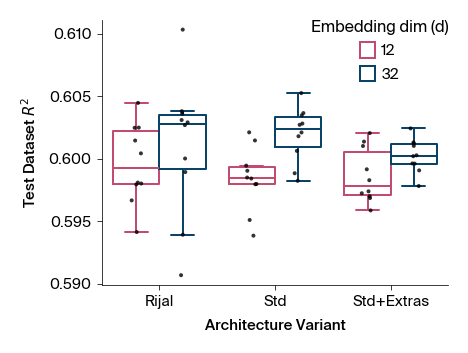

In [9]:
# | code-fold: true
# | label: fig-std-comp
# | fig-cap: Comparison of test dataset $R^2$ values between the model variants described above.

import seaborn as sns

label_lookup = {
    "rijal": "Rijal",
    "std": "Std",
    "std_extras": "Std+Extras",
}

data = {"Architecture": [], "Embedding dim": [], "Replicate": [], "Test dataset R²": []}
for model_dir in model_dirs:
    dir_name = model_dir.parent.parent.name  # e.g., "std_extras_d12_rep_09"
    variant_key, _, rep_str = dir_name.rpartition("_rep_")
    base_arch_key, _, dim_str = variant_key.rpartition("_d")
    architecture_label = label_lookup[base_arch_key]
    embedding_dim = int(dim_str)
    replicate = int(rep_str)
    r2_score = get_test_r2(model_dir)

    data["Architecture"].append(architecture_label)
    data["Embedding dim"].append(embedding_dim)
    data["Replicate"].append(replicate)
    data["Test dataset R²"].append(r2_score)


df = pd.DataFrame(data)
plt.figure()  # Adjust figure size if needed

colors = [apc.azalea, apc.dusk]
datapoints_color = "#000000CC"
sns.boxplot(
    data=df,
    x="Architecture",
    y="Test dataset R²",
    hue="Embedding dim",
    order=["Rijal", "Std", "Std+Extras"],
    showfliers=False,
    fill=False,
    hue_order=[12, 32],
    palette=colors,
)

sns.stripplot(
    data=df,
    x="Architecture",
    y="Test dataset R²",
    hue="Embedding dim",
    order=["Rijal", "Std", "Std+Extras"],
    hue_order=[12, 32],
    size=4,
    palette=[datapoints_color] * 2,
    dodge=True,
)

handles, labels = plt.gca().get_legend_handles_labels()
num_hues = len(df["Embedding dim"].unique())
plt.xlabel("Architecture Variant")
plt.ylabel("Test Dataset $R^2$")
plt.legend(handles[:num_hues], labels[:num_hues], title="Embedding dim (d)")
plt.tight_layout()
plt.show()

Our main takeaways from @fig-std-comp:

* Replacing the home-brewed elements (Rijal) with more standard elements (Std) doesn't impact performance, and seems to stabilize training, leading to lower run-to-run variance.
* Increasing the hidden dimension $d$ from 12 to 32 does increase model performance, though the effect is slight.
* Adding skip connections, dropout, and using scaled dot product attention doesn't improve model performance.

TODO:George Is there something smrt we can say here regarding this third point?

# Retrying on their simulated data

@fig-std-comp illustrates that adding model components present in transformer architectures didn't lead to the increase in model performance we were expecting. Is this a feature of the dataset or the architecture? To find out, we trained the same model on the maximally epistatic simulated data ($\epsilon = 0.0$) found in @Rijal2025.

To save compute, we only ran this for $d=32$ and reduced the number of replicates to $6$.

In [ ]:
# | code-fold: true
SEQ_LENGTH = 100
NUM_LAYERS = 3
PHENOTYPE = "synth"
NUM_REPLICATES = 6

variants = [
    # d=32 Variants
    {
        "name": "rijal_d32",
        "model_type": "rijal_et_al",
        "embedding_dim": 33,  # Rijal needs +1 dim
        "model_config_override": {},
    },
    {
        "name": "std_d32",
        "model_type": "modified",
        "embedding_dim": 32,
        "model_config_override": {
            "skip_connections": False,
            "scaled_attention": False,
            "dropout_rate": 0.0,
        },
    },
    {
        "name": "std_extras_d32",
        "model_type": "modified",
        "embedding_dim": 32,
        "model_config_override": {
            "skip_connections": True,
            "scaled_attention": True,
            "dropout_rate": 0.1,
        },
    },
]

jobs = []

for variant in variants:
    for i in range(NUM_REPLICATES):
        replicate_id = f"{i:02d}"
        job_name_prefix = f"{variant['name']}_rep_{replicate_id}"

        model_config_params = {
            "model_type": variant["model_type"],
            "seq_length": SEQ_LENGTH,
            "embedding_dim": variant["embedding_dim"],
            "num_layers": NUM_LAYERS,
            "init_scale": 4e-3,  # Match Rijal et al
        }
        model_config_params.update(variant["model_config_override"])
        model_config = ModelConfig(**model_config_params)

        train_config = attrs.evolve(
            train_template_config,
            save_dir=Path("models/simulated"),
            max_epochs=500,  # Match Rijal et al
            synthetic_data=True,
            phenotypes=[PHENOTYPE],
            name_prefix=job_name_prefix,
            optimizer="adamw",
        )

        jobs.append((model_config, train_config))

print(f"\nGenerated {len(jobs)} job configurations.")


Generated 18 job configurations.


In [12]:
model_dirs = run_trainings(jobs)

Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='rijal_et_al',     │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=33,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 33                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'rijal_et_al'      │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭─────────────────────── <class 'analysis.base.TrainConfig'> ────────────────────────╮
│ ╭────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                   │ │
│ │ │   data_dir=PosixPath('datasets'),                                            │ │
│ │ │   synthetic_data=False,                                                      │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                    │ │
│ │ │   name_prefix='rijal_d32_rep_00',                                            │ │
│ │ │   phenotypes=['mann'],                                                       │ │
│ │ │   optimizer='adamw',                                                         │ │
│ │ │   patience=200,                                                              │ │
│ │ │   batch_size=64,                                                             │ │
│ │ │   learning_rate=0.001,                                                       │ │
│ │ │   lr_schedule=False,                                                         │ │
│ │ │   weight_decay=0.0,                                                          │ │
│ │ │   max_epochs=500,                                                            │ │
│ │ │   num_workers=1,                                                             │ │
│ │ │   gradient_clip_val=0,                                                       │ │
│ │ │   use_cache=True,                                                            │ │
│ │ │   use_modal=True,                                                            │ │
│ │ │   modal_detach=True,                                                         │ │
│ │ │   seed=None                                                                  │ │
│ │ )                                                                              │ │
│ ╰────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                    │
│         batch_size = 64                                                            │
│           data_dir = PosixPath('datasets')                                         │
│ expected_model_dir = PosixPath('models/simulated/rijal_d32_rep_00/lightning_logs') │
│  gradient_clip_val = 0                                                             │
│      learning_rate = 0.001                                                         │
│        lr_schedule = False                                                         │
│         max_epochs = 500                                                           │
│       modal_detach = True                                                          │
│        name_prefix = 'rijal_d32_rep_00'                                            │
│     num_phenotypes = 1                                                             │
│        num_workers = 1                                                             │
│          optimizer = 'adamw'                                                       │
│           patience = 200                                                           │
│         phenotypes = ['mann']                                                      │
│           save_dir = PosixPath('models/simulated')                                 │
│               seed = None                                                          │
│     synthetic_data = False                                                         │
│          use_cache = True                                                          │
│          use_modal = True                                                          │
│       weight_decay = 0.0                                                           │
╰────────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='rijal_et_al',     │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=33,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 33                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'rijal_et_al'      │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭─────────────────────── <class 'analysis.base.TrainConfig'> ────────────────────────╮
│ ╭────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                   │ │
│ │ │   data_dir=PosixPath('datasets'),                                            │ │
│ │ │   synthetic_data=False,                                                      │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                    │ │
│ │ │   name_prefix='rijal_d32_rep_01',                                            │ │
│ │ │   phenotypes=['mann'],                                                       │ │
│ │ │   optimizer='adamw',                                                         │ │
│ │ │   patience=200,                                                              │ │
│ │ │   batch_size=64,                                                             │ │
│ │ │   learning_rate=0.001,                                                       │ │
│ │ │   lr_schedule=False,                                                         │ │
│ │ │   weight_decay=0.0,                                                          │ │
│ │ │   max_epochs=500,                                                            │ │
│ │ │   num_workers=1,                                                             │ │
│ │ │   gradient_clip_val=0,                                                       │ │
│ │ │   use_cache=True,                                                            │ │
│ │ │   use_modal=True,                                                            │ │
│ │ │   modal_detach=True,                                                         │ │
│ │ │   seed=None                                                                  │ │
│ │ )                                                                              │ │
│ ╰────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                    │
│         batch_size = 64                                                            │
│           data_dir = PosixPath('datasets')                                         │
│ expected_model_dir = PosixPath('models/simulated/rijal_d32_rep_01/lightning_logs') │
│  gradient_clip_val = 0                                                             │
│      learning_rate = 0.001                                                         │
│        lr_schedule = False                                                         │
│         max_epochs = 500                                                           │
│       modal_detach = True                                                          │
│        name_prefix = 'rijal_d32_rep_01'                                            │
│     num_phenotypes = 1                                                             │
│        num_workers = 1                                                             │
│          optimizer = 'adamw'                                                       │
│           patience = 200                                                           │
│         phenotypes = ['mann']                                                      │
│           save_dir = PosixPath('models/simulated')                                 │
│               seed = None                                                          │
│     synthetic_data = False                                                         │
│          use_cache = True                                                          │
│          use_modal = True                                                          │
│       weight_decay = 0.0                                                           │
╰────────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='rijal_et_al',     │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=33,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 33                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'rijal_et_al'      │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭─────────────────────── <class 'analysis.base.TrainConfig'> ────────────────────────╮
│ ╭────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                   │ │
│ │ │   data_dir=PosixPath('datasets'),                                            │ │
│ │ │   synthetic_data=False,                                                      │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                    │ │
│ │ │   name_prefix='rijal_d32_rep_02',                                            │ │
│ │ │   phenotypes=['mann'],                                                       │ │
│ │ │   optimizer='adamw',                                                         │ │
│ │ │   patience=200,                                                              │ │
│ │ │   batch_size=64,                                                             │ │
│ │ │   learning_rate=0.001,                                                       │ │
│ │ │   lr_schedule=False,                                                         │ │
│ │ │   weight_decay=0.0,                                                          │ │
│ │ │   max_epochs=500,                                                            │ │
│ │ │   num_workers=1,                                                             │ │
│ │ │   gradient_clip_val=0,                                                       │ │
│ │ │   use_cache=True,                                                            │ │
│ │ │   use_modal=True,                                                            │ │
│ │ │   modal_detach=True,                                                         │ │
│ │ │   seed=None                                                                  │ │
│ │ )                                                                              │ │
│ ╰────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                    │
│         batch_size = 64                                                            │
│           data_dir = PosixPath('datasets')                                         │
│ expected_model_dir = PosixPath('models/simulated/rijal_d32_rep_02/lightning_logs') │
│  gradient_clip_val = 0                                                             │
│      learning_rate = 0.001                                                         │
│        lr_schedule = False                                                         │
│         max_epochs = 500                                                           │
│       modal_detach = True                                                          │
│        name_prefix = 'rijal_d32_rep_02'                                            │
│     num_phenotypes = 1                                                             │
│        num_workers = 1                                                             │
│          optimizer = 'adamw'                                                       │
│           patience = 200                                                           │
│         phenotypes = ['mann']                                                      │
│           save_dir = PosixPath('models/simulated')                                 │
│               seed = None                                                          │
│     synthetic_data = False                                                         │
│          use_cache = True                                                          │
│          use_modal = True                                                          │
│       weight_decay = 0.0                                                           │
╰────────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='rijal_et_al',     │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=33,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 33                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'rijal_et_al'      │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭─────────────────────── <class 'analysis.base.TrainConfig'> ────────────────────────╮
│ ╭────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                   │ │
│ │ │   data_dir=PosixPath('datasets'),                                            │ │
│ │ │   synthetic_data=False,                                                      │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                    │ │
│ │ │   name_prefix='rijal_d32_rep_03',                                            │ │
│ │ │   phenotypes=['mann'],                                                       │ │
│ │ │   optimizer='adamw',                                                         │ │
│ │ │   patience=200,                                                              │ │
│ │ │   batch_size=64,                                                             │ │
│ │ │   learning_rate=0.001,                                                       │ │
│ │ │   lr_schedule=False,                                                         │ │
│ │ │   weight_decay=0.0,                                                          │ │
│ │ │   max_epochs=500,                                                            │ │
│ │ │   num_workers=1,                                                             │ │
│ │ │   gradient_clip_val=0,                                                       │ │
│ │ │   use_cache=True,                                                            │ │
│ │ │   use_modal=True,                                                            │ │
│ │ │   modal_detach=True,                                                         │ │
│ │ │   seed=None                                                                  │ │
│ │ )                                                                              │ │
│ ╰────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                    │
│         batch_size = 64                                                            │
│           data_dir = PosixPath('datasets')                                         │
│ expected_model_dir = PosixPath('models/simulated/rijal_d32_rep_03/lightning_logs') │
│  gradient_clip_val = 0                                                             │
│      learning_rate = 0.001                                                         │
│        lr_schedule = False                                                         │
│         max_epochs = 500                                                           │
│       modal_detach = True                                                          │
│        name_prefix = 'rijal_d32_rep_03'                                            │
│     num_phenotypes = 1                                                             │
│        num_workers = 1                                                             │
│          optimizer = 'adamw'                                                       │
│           patience = 200                                                           │
│         phenotypes = ['mann']                                                      │
│           save_dir = PosixPath('models/simulated')                                 │
│               seed = None                                                          │
│     synthetic_data = False                                                         │
│          use_cache = True                                                          │
│          use_modal = True                                                          │
│       weight_decay = 0.0                                                           │
╰────────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='rijal_et_al',     │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=33,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 33                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'rijal_et_al'      │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭─────────────────────── <class 'analysis.base.TrainConfig'> ────────────────────────╮
│ ╭────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                   │ │
│ │ │   data_dir=PosixPath('datasets'),                                            │ │
│ │ │   synthetic_data=False,                                                      │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                    │ │
│ │ │   name_prefix='rijal_d32_rep_04',                                            │ │
│ │ │   phenotypes=['mann'],                                                       │ │
│ │ │   optimizer='adamw',                                                         │ │
│ │ │   patience=200,                                                              │ │
│ │ │   batch_size=64,                                                             │ │
│ │ │   learning_rate=0.001,                                                       │ │
│ │ │   lr_schedule=False,                                                         │ │
│ │ │   weight_decay=0.0,                                                          │ │
│ │ │   max_epochs=500,                                                            │ │
│ │ │   num_workers=1,                                                             │ │
│ │ │   gradient_clip_val=0,                                                       │ │
│ │ │   use_cache=True,                                                            │ │
│ │ │   use_modal=True,                                                            │ │
│ │ │   modal_detach=True,                                                         │ │
│ │ │   seed=None                                                                  │ │
│ │ )                                                                              │ │
│ ╰────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                    │
│         batch_size = 64                                                            │
│           data_dir = PosixPath('datasets')                                         │
│ expected_model_dir = PosixPath('models/simulated/rijal_d32_rep_04/lightning_logs') │
│  gradient_clip_val = 0                                                             │
│      learning_rate = 0.001                                                         │
│        lr_schedule = False                                                         │
│         max_epochs = 500                                                           │
│       modal_detach = True                                                          │
│        name_prefix = 'rijal_d32_rep_04'                                            │
│     num_phenotypes = 1                                                             │
│        num_workers = 1                                                             │
│          optimizer = 'adamw'                                                       │
│           patience = 200                                                           │
│         phenotypes = ['mann']                                                      │
│           save_dir = PosixPath('models/simulated')                                 │
│               seed = None                                                          │
│     synthetic_data = False                                                         │
│          use_cache = True                                                          │
│          use_modal = True                                                          │
│       weight_decay = 0.0                                                           │
╰────────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='rijal_et_al',     │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=33,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 33                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'rijal_et_al'      │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭─────────────────────── <class 'analysis.base.TrainConfig'> ────────────────────────╮
│ ╭────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                   │ │
│ │ │   data_dir=PosixPath('datasets'),                                            │ │
│ │ │   synthetic_data=False,                                                      │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                    │ │
│ │ │   name_prefix='rijal_d32_rep_05',                                            │ │
│ │ │   phenotypes=['mann'],                                                       │ │
│ │ │   optimizer='adamw',                                                         │ │
│ │ │   patience=200,                                                              │ │
│ │ │   batch_size=64,                                                             │ │
│ │ │   learning_rate=0.001,                                                       │ │
│ │ │   lr_schedule=False,                                                         │ │
│ │ │   weight_decay=0.0,                                                          │ │
│ │ │   max_epochs=500,                                                            │ │
│ │ │   num_workers=1,                                                             │ │
│ │ │   gradient_clip_val=0,                                                       │ │
│ │ │   use_cache=True,                                                            │ │
│ │ │   use_modal=True,                                                            │ │
│ │ │   modal_detach=True,                                                         │ │
│ │ │   seed=None                                                                  │ │
│ │ )                                                                              │ │
│ ╰────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                    │
│         batch_size = 64                                                            │
│           data_dir = PosixPath('datasets')                                         │
│ expected_model_dir = PosixPath('models/simulated/rijal_d32_rep_05/lightning_logs') │
│  gradient_clip_val = 0                                                             │
│      learning_rate = 0.001                                                         │
│        lr_schedule = False                                                         │
│         max_epochs = 500                                                           │
│       modal_detach = True                                                          │
│        name_prefix = 'rijal_d32_rep_05'                                            │
│     num_phenotypes = 1                                                             │
│        num_workers = 1                                                             │
│          optimizer = 'adamw'                                                       │
│           patience = 200                                                           │
│         phenotypes = ['mann']                                                      │
│           save_dir = PosixPath('models/simulated')                                 │
│               seed = None                                                          │
│     synthetic_data = False                                                         │
│          use_cache = True                                                          │
│          use_modal = True                                                          │
│       weight_decay = 0.0                                                           │
╰────────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────── <class 'analysis.base.TrainConfig'> ───────────────────────╮
│ ╭──────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                 │ │
│ │ │   data_dir=PosixPath('datasets'),                                          │ │
│ │ │   synthetic_data=False,                                                    │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                  │ │
│ │ │   name_prefix='std_d32_rep_00',                                            │ │
│ │ │   phenotypes=['mann'],                                                     │ │
│ │ │   optimizer='adamw',                                                       │ │
│ │ │   patience=200,                                                            │ │
│ │ │   batch_size=64,                                                           │ │
│ │ │   learning_rate=0.001,                                                     │ │
│ │ │   lr_schedule=False,                                                       │ │
│ │ │   weight_decay=0.0,                                                        │ │
│ │ │   max_epochs=500,                                                          │ │
│ │ │   num_workers=1,                                                           │ │
│ │ │   gradient_clip_val=0,                                                     │ │
│ │ │   use_cache=True,                                                          │ │
│ │ │   use_modal=True,                                                          │ │
│ │ │   modal_detach=True,                                                       │ │
│ │ │   seed=None                                                                │ │
│ │ )                                                                            │ │
│ ╰──────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                  │
│         batch_size = 64                                                          │
│           data_dir = PosixPath('datasets')                                       │
│ expected_model_dir = PosixPath('models/simulated/std_d32_rep_00/lightning_logs') │
│  gradient_clip_val = 0                                                           │
│      learning_rate = 0.001                                                       │
│        lr_schedule = False                                                       │
│         max_epochs = 500                                                         │
│       modal_detach = True                                                        │
│        name_prefix = 'std_d32_rep_00'                                            │
│     num_phenotypes = 1                                                           │
│        num_workers = 1                                                           │
│          optimizer = 'adamw'                                                     │
│           patience = 200                                                         │
│         phenotypes = ['mann']                                                    │
│           save_dir = PosixPath('models/simulated')                               │
│               seed = None                                                        │
│     synthetic_data = False                                                       │
│          use_cache = True                                                        │
│          use_modal = True                                                        │
│       weight_decay = 0.0                                                         │
╰──────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────── <class 'analysis.base.TrainConfig'> ───────────────────────╮
│ ╭──────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                 │ │
│ │ │   data_dir=PosixPath('datasets'),                                          │ │
│ │ │   synthetic_data=False,                                                    │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                  │ │
│ │ │   name_prefix='std_d32_rep_01',                                            │ │
│ │ │   phenotypes=['mann'],                                                     │ │
│ │ │   optimizer='adamw',                                                       │ │
│ │ │   patience=200,                                                            │ │
│ │ │   batch_size=64,                                                           │ │
│ │ │   learning_rate=0.001,                                                     │ │
│ │ │   lr_schedule=False,                                                       │ │
│ │ │   weight_decay=0.0,                                                        │ │
│ │ │   max_epochs=500,                                                          │ │
│ │ │   num_workers=1,                                                           │ │
│ │ │   gradient_clip_val=0,                                                     │ │
│ │ │   use_cache=True,                                                          │ │
│ │ │   use_modal=True,                                                          │ │
│ │ │   modal_detach=True,                                                       │ │
│ │ │   seed=None                                                                │ │
│ │ )                                                                            │ │
│ ╰──────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                  │
│         batch_size = 64                                                          │
│           data_dir = PosixPath('datasets')                                       │
│ expected_model_dir = PosixPath('models/simulated/std_d32_rep_01/lightning_logs') │
│  gradient_clip_val = 0                                                           │
│      learning_rate = 0.001                                                       │
│        lr_schedule = False                                                       │
│         max_epochs = 500                                                         │
│       modal_detach = True                                                        │
│        name_prefix = 'std_d32_rep_01'                                            │
│     num_phenotypes = 1                                                           │
│        num_workers = 1                                                           │
│          optimizer = 'adamw'                                                     │
│           patience = 200                                                         │
│         phenotypes = ['mann']                                                    │
│           save_dir = PosixPath('models/simulated')                               │
│               seed = None                                                        │
│     synthetic_data = False                                                       │
│          use_cache = True                                                        │
│          use_modal = True                                                        │
│       weight_decay = 0.0                                                         │
╰──────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────── <class 'analysis.base.TrainConfig'> ───────────────────────╮
│ ╭──────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                 │ │
│ │ │   data_dir=PosixPath('datasets'),                                          │ │
│ │ │   synthetic_data=False,                                                    │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                  │ │
│ │ │   name_prefix='std_d32_rep_02',                                            │ │
│ │ │   phenotypes=['mann'],                                                     │ │
│ │ │   optimizer='adamw',                                                       │ │
│ │ │   patience=200,                                                            │ │
│ │ │   batch_size=64,                                                           │ │
│ │ │   learning_rate=0.001,                                                     │ │
│ │ │   lr_schedule=False,                                                       │ │
│ │ │   weight_decay=0.0,                                                        │ │
│ │ │   max_epochs=500,                                                          │ │
│ │ │   num_workers=1,                                                           │ │
│ │ │   gradient_clip_val=0,                                                     │ │
│ │ │   use_cache=True,                                                          │ │
│ │ │   use_modal=True,                                                          │ │
│ │ │   modal_detach=True,                                                       │ │
│ │ │   seed=None                                                                │ │
│ │ )                                                                            │ │
│ ╰──────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                  │
│         batch_size = 64                                                          │
│           data_dir = PosixPath('datasets')                                       │
│ expected_model_dir = PosixPath('models/simulated/std_d32_rep_02/lightning_logs') │
│  gradient_clip_val = 0                                                           │
│      learning_rate = 0.001                                                       │
│        lr_schedule = False                                                       │
│         max_epochs = 500                                                         │
│       modal_detach = True                                                        │
│        name_prefix = 'std_d32_rep_02'                                            │
│     num_phenotypes = 1                                                           │
│        num_workers = 1                                                           │
│          optimizer = 'adamw'                                                     │
│           patience = 200                                                         │
│         phenotypes = ['mann']                                                    │
│           save_dir = PosixPath('models/simulated')                               │
│               seed = None                                                        │
│     synthetic_data = False                                                       │
│          use_cache = True                                                        │
│          use_modal = True                                                        │
│       weight_decay = 0.0                                                         │
╰──────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────── <class 'analysis.base.TrainConfig'> ───────────────────────╮
│ ╭──────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                 │ │
│ │ │   data_dir=PosixPath('datasets'),                                          │ │
│ │ │   synthetic_data=False,                                                    │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                  │ │
│ │ │   name_prefix='std_d32_rep_03',                                            │ │
│ │ │   phenotypes=['mann'],                                                     │ │
│ │ │   optimizer='adamw',                                                       │ │
│ │ │   patience=200,                                                            │ │
│ │ │   batch_size=64,                                                           │ │
│ │ │   learning_rate=0.001,                                                     │ │
│ │ │   lr_schedule=False,                                                       │ │
│ │ │   weight_decay=0.0,                                                        │ │
│ │ │   max_epochs=500,                                                          │ │
│ │ │   num_workers=1,                                                           │ │
│ │ │   gradient_clip_val=0,                                                     │ │
│ │ │   use_cache=True,                                                          │ │
│ │ │   use_modal=True,                                                          │ │
│ │ │   modal_detach=True,                                                       │ │
│ │ │   seed=None                                                                │ │
│ │ )                                                                            │ │
│ ╰──────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                  │
│         batch_size = 64                                                          │
│           data_dir = PosixPath('datasets')                                       │
│ expected_model_dir = PosixPath('models/simulated/std_d32_rep_03/lightning_logs') │
│  gradient_clip_val = 0                                                           │
│      learning_rate = 0.001                                                       │
│        lr_schedule = False                                                       │
│         max_epochs = 500                                                         │
│       modal_detach = True                                                        │
│        name_prefix = 'std_d32_rep_03'                                            │
│     num_phenotypes = 1                                                           │
│        num_workers = 1                                                           │
│          optimizer = 'adamw'                                                     │
│           patience = 200                                                         │
│         phenotypes = ['mann']                                                    │
│           save_dir = PosixPath('models/simulated')                               │
│               seed = None                                                        │
│     synthetic_data = False                                                       │
│          use_cache = True                                                        │
│          use_modal = True                                                        │
│       weight_decay = 0.0                                                         │
╰──────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────── <class 'analysis.base.TrainConfig'> ───────────────────────╮
│ ╭──────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                 │ │
│ │ │   data_dir=PosixPath('datasets'),                                          │ │
│ │ │   synthetic_data=False,                                                    │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                  │ │
│ │ │   name_prefix='std_d32_rep_04',                                            │ │
│ │ │   phenotypes=['mann'],                                                     │ │
│ │ │   optimizer='adamw',                                                       │ │
│ │ │   patience=200,                                                            │ │
│ │ │   batch_size=64,                                                           │ │
│ │ │   learning_rate=0.001,                                                     │ │
│ │ │   lr_schedule=False,                                                       │ │
│ │ │   weight_decay=0.0,                                                        │ │
│ │ │   max_epochs=500,                                                          │ │
│ │ │   num_workers=1,                                                           │ │
│ │ │   gradient_clip_val=0,                                                     │ │
│ │ │   use_cache=True,                                                          │ │
│ │ │   use_modal=True,                                                          │ │
│ │ │   modal_detach=True,                                                       │ │
│ │ │   seed=None                                                                │ │
│ │ )                                                                            │ │
│ ╰──────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                  │
│         batch_size = 64                                                          │
│           data_dir = PosixPath('datasets')                                       │
│ expected_model_dir = PosixPath('models/simulated/std_d32_rep_04/lightning_logs') │
│  gradient_clip_val = 0                                                           │
│      learning_rate = 0.001                                                       │
│        lr_schedule = False                                                       │
│         max_epochs = 500                                                         │
│       modal_detach = True                                                        │
│        name_prefix = 'std_d32_rep_04'                                            │
│     num_phenotypes = 1                                                           │
│        num_workers = 1                                                           │
│          optimizer = 'adamw'                                                     │
│           patience = 200                                                         │
│         phenotypes = ['mann']                                                    │
│           save_dir = PosixPath('models/simulated')                               │
│               seed = None                                                        │
│     synthetic_data = False                                                       │
│          use_cache = True                                                        │
│          use_modal = True                                                        │
│       weight_decay = 0.0                                                         │
╰──────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=False,       │ │
│ │ │   scaled_attention=False,       │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.0              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.0                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = False              │
│       seq_length = 100                │
│ skip_connections = False              │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────── <class 'analysis.base.TrainConfig'> ───────────────────────╮
│ ╭──────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                 │ │
│ │ │   data_dir=PosixPath('datasets'),                                          │ │
│ │ │   synthetic_data=False,                                                    │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                  │ │
│ │ │   name_prefix='std_d32_rep_05',                                            │ │
│ │ │   phenotypes=['mann'],                                                     │ │
│ │ │   optimizer='adamw',                                                       │ │
│ │ │   patience=200,                                                            │ │
│ │ │   batch_size=64,                                                           │ │
│ │ │   learning_rate=0.001,                                                     │ │
│ │ │   lr_schedule=False,                                                       │ │
│ │ │   weight_decay=0.0,                                                        │ │
│ │ │   max_epochs=500,                                                          │ │
│ │ │   num_workers=1,                                                           │ │
│ │ │   gradient_clip_val=0,                                                     │ │
│ │ │   use_cache=True,                                                          │ │
│ │ │   use_modal=True,                                                          │ │
│ │ │   modal_detach=True,                                                       │ │
│ │ │   seed=None                                                                │ │
│ │ )                                                                            │ │
│ ╰──────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                  │
│         batch_size = 64                                                          │
│           data_dir = PosixPath('datasets')                                       │
│ expected_model_dir = PosixPath('models/simulated/std_d32_rep_05/lightning_logs') │
│  gradient_clip_val = 0                                                           │
│      learning_rate = 0.001                                                       │
│        lr_schedule = False                                                       │
│         max_epochs = 500                                                         │
│       modal_detach = True                                                        │
│        name_prefix = 'std_d32_rep_05'                                            │
│     num_phenotypes = 1                                                           │
│        num_workers = 1                                                           │
│          optimizer = 'adamw'                                                     │
│           patience = 200                                                         │
│         phenotypes = ['mann']                                                    │
│           save_dir = PosixPath('models/simulated')                               │
│               seed = None                                                        │
│     synthetic_data = False                                                       │
│          use_cache = True                                                        │
│          use_modal = True                                                        │
│       weight_decay = 0.0                                                         │
╰──────────────────────────────────────────────────────────────────────────────────╯

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=True,        │ │
│ │ │   scaled_attention=True,        │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.1              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.1                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = True               │
│       seq_length = 100                │
│ skip_connections = True               │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────────── <class 'analysis.base.TrainConfig'> ──────────────────────────╮
│ ╭─────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                        │ │
│ │ │   data_dir=PosixPath('datasets'),                                                 │ │
│ │ │   synthetic_data=False,                                                           │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                         │ │
│ │ │   name_prefix='std_extras_d32_rep_00',                                            │ │
│ │ │   phenotypes=['mann'],                                                            │ │
│ │ │   optimizer='adamw',                                                              │ │
│ │ │   patience=200,                                                                   │ │
│ │ │   batch_size=64,                                                                  │ │
│ │ │   learning_rate=0.001,                                                            │ │
│ │ │   lr_schedule=False,                                                              │ │
│ │ │   weight_decay=0.0,                                                               │ │
│ │ │   max_epochs=500,                                                                 │ │
│ │ │   num_workers=1,                                                                  │ │
│ │ │   gradient_clip_val=0,                                                            │ │
│ │ │   use_cache=True,                                                                 │ │
│ │ │   use_modal=True,                                                                 │ │
│ │ │   modal_detach=True,                                                              │ │
│ │ │   seed=None                                                                       │ │
│ │ )                                                                                   │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                         │
│         batch_size = 64                                                                 │
│           data_dir = PosixPath('datasets')                                              │
│ expected_model_dir = PosixPath('models/simulated/std_extras_d32_rep_00/lightning_logs') │
│  gradient_clip_val = 0                                                                  │
│      learning_rate = 0.001                                                              │
│        lr_schedule = False                                                              │
│         max_epochs = 500                                                                │
│       modal_detach = True                                                               │
│        name_prefix = 'std_extras_d32_rep_00'                                            │
│     num_phenotypes = 1                                                                  │
│        num_workers = 1                                                                  │
│          optimizer = 'adamw'                                                            │
│           patience = 200                                                                │
│         phenotypes = ['mann']                                                           │
│           save_dir = PosixPath('models/simulated')                                      │
│               seed = None                                                               │
│     synthetic_data = False                                                              │
│          use_cache = True                                                               │
│          use_modal = True                                                               │
│       weight_decay = 0.0                  

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=True,        │ │
│ │ │   scaled_attention=True,        │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.1              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.1                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = True               │
│       seq_length = 100                │
│ skip_connections = True               │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────────── <class 'analysis.base.TrainConfig'> ──────────────────────────╮
│ ╭─────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                        │ │
│ │ │   data_dir=PosixPath('datasets'),                                                 │ │
│ │ │   synthetic_data=False,                                                           │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                         │ │
│ │ │   name_prefix='std_extras_d32_rep_01',                                            │ │
│ │ │   phenotypes=['mann'],                                                            │ │
│ │ │   optimizer='adamw',                                                              │ │
│ │ │   patience=200,                                                                   │ │
│ │ │   batch_size=64,                                                                  │ │
│ │ │   learning_rate=0.001,                                                            │ │
│ │ │   lr_schedule=False,                                                              │ │
│ │ │   weight_decay=0.0,                                                               │ │
│ │ │   max_epochs=500,                                                                 │ │
│ │ │   num_workers=1,                                                                  │ │
│ │ │   gradient_clip_val=0,                                                            │ │
│ │ │   use_cache=True,                                                                 │ │
│ │ │   use_modal=True,                                                                 │ │
│ │ │   modal_detach=True,                                                              │ │
│ │ │   seed=None                                                                       │ │
│ │ )                                                                                   │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                         │
│         batch_size = 64                                                                 │
│           data_dir = PosixPath('datasets')                                              │
│ expected_model_dir = PosixPath('models/simulated/std_extras_d32_rep_01/lightning_logs') │
│  gradient_clip_val = 0                                                                  │
│      learning_rate = 0.001                                                              │
│        lr_schedule = False                                                              │
│         max_epochs = 500                                                                │
│       modal_detach = True                                                               │
│        name_prefix = 'std_extras_d32_rep_01'                                            │
│     num_phenotypes = 1                                                                  │
│        num_workers = 1                                                                  │
│          optimizer = 'adamw'                                                            │
│           patience = 200                                                                │
│         phenotypes = ['mann']                                                           │
│           save_dir = PosixPath('models/simulated')                                      │
│               seed = None                                                               │
│     synthetic_data = False                                                              │
│          use_cache = True                                                               │
│          use_modal = True                                                               │
│       weight_decay = 0.0                  

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=True,        │ │
│ │ │   scaled_attention=True,        │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.1              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.1                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = True               │
│       seq_length = 100                │
│ skip_connections = True               │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────────── <class 'analysis.base.TrainConfig'> ──────────────────────────╮
│ ╭─────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                        │ │
│ │ │   data_dir=PosixPath('datasets'),                                                 │ │
│ │ │   synthetic_data=False,                                                           │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                         │ │
│ │ │   name_prefix='std_extras_d32_rep_02',                                            │ │
│ │ │   phenotypes=['mann'],                                                            │ │
│ │ │   optimizer='adamw',                                                              │ │
│ │ │   patience=200,                                                                   │ │
│ │ │   batch_size=64,                                                                  │ │
│ │ │   learning_rate=0.001,                                                            │ │
│ │ │   lr_schedule=False,                                                              │ │
│ │ │   weight_decay=0.0,                                                               │ │
│ │ │   max_epochs=500,                                                                 │ │
│ │ │   num_workers=1,                                                                  │ │
│ │ │   gradient_clip_val=0,                                                            │ │
│ │ │   use_cache=True,                                                                 │ │
│ │ │   use_modal=True,                                                                 │ │
│ │ │   modal_detach=True,                                                              │ │
│ │ │   seed=None                                                                       │ │
│ │ )                                                                                   │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                         │
│         batch_size = 64                                                                 │
│           data_dir = PosixPath('datasets')                                              │
│ expected_model_dir = PosixPath('models/simulated/std_extras_d32_rep_02/lightning_logs') │
│  gradient_clip_val = 0                                                                  │
│      learning_rate = 0.001                                                              │
│        lr_schedule = False                                                              │
│         max_epochs = 500                                                                │
│       modal_detach = True                                                               │
│        name_prefix = 'std_extras_d32_rep_02'                                            │
│     num_phenotypes = 1                                                                  │
│        num_workers = 1                                                                  │
│          optimizer = 'adamw'                                                            │
│           patience = 200                                                                │
│         phenotypes = ['mann']                                                           │
│           save_dir = PosixPath('models/simulated')                                      │
│               seed = None                                                               │
│     synthetic_data = False                                                              │
│          use_cache = True                                                               │
│          use_modal = True                                                               │
│       weight_decay = 0.0                  

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=True,        │ │
│ │ │   scaled_attention=True,        │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.1              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.1                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = True               │
│       seq_length = 100                │
│ skip_connections = True               │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────────── <class 'analysis.base.TrainConfig'> ──────────────────────────╮
│ ╭─────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                        │ │
│ │ │   data_dir=PosixPath('datasets'),                                                 │ │
│ │ │   synthetic_data=False,                                                           │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                         │ │
│ │ │   name_prefix='std_extras_d32_rep_03',                                            │ │
│ │ │   phenotypes=['mann'],                                                            │ │
│ │ │   optimizer='adamw',                                                              │ │
│ │ │   patience=200,                                                                   │ │
│ │ │   batch_size=64,                                                                  │ │
│ │ │   learning_rate=0.001,                                                            │ │
│ │ │   lr_schedule=False,                                                              │ │
│ │ │   weight_decay=0.0,                                                               │ │
│ │ │   max_epochs=500,                                                                 │ │
│ │ │   num_workers=1,                                                                  │ │
│ │ │   gradient_clip_val=0,                                                            │ │
│ │ │   use_cache=True,                                                                 │ │
│ │ │   use_modal=True,                                                                 │ │
│ │ │   modal_detach=True,                                                              │ │
│ │ │   seed=None                                                                       │ │
│ │ )                                                                                   │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                         │
│         batch_size = 64                                                                 │
│           data_dir = PosixPath('datasets')                                              │
│ expected_model_dir = PosixPath('models/simulated/std_extras_d32_rep_03/lightning_logs') │
│  gradient_clip_val = 0                                                                  │
│      learning_rate = 0.001                                                              │
│        lr_schedule = False                                                              │
│         max_epochs = 500                                                                │
│       modal_detach = True                                                               │
│        name_prefix = 'std_extras_d32_rep_03'                                            │
│     num_phenotypes = 1                                                                  │
│        num_workers = 1                                                                  │
│          optimizer = 'adamw'                                                            │
│           patience = 200                                                                │
│         phenotypes = ['mann']                                                           │
│           save_dir = PosixPath('models/simulated')                                      │
│               seed = None                                                               │
│     synthetic_data = False                                                              │
│          use_cache = True                                                               │
│          use_modal = True                                                               │
│       weight_decay = 0.0                  

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=True,        │ │
│ │ │   scaled_attention=True,        │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.1              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.1                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = True               │
│       seq_length = 100                │
│ skip_connections = True               │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────────── <class 'analysis.base.TrainConfig'> ──────────────────────────╮
│ ╭─────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                        │ │
│ │ │   data_dir=PosixPath('datasets'),                                                 │ │
│ │ │   synthetic_data=False,                                                           │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                         │ │
│ │ │   name_prefix='std_extras_d32_rep_04',                                            │ │
│ │ │   phenotypes=['mann'],                                                            │ │
│ │ │   optimizer='adamw',                                                              │ │
│ │ │   patience=200,                                                                   │ │
│ │ │   batch_size=64,                                                                  │ │
│ │ │   learning_rate=0.001,                                                            │ │
│ │ │   lr_schedule=False,                                                              │ │
│ │ │   weight_decay=0.0,                                                               │ │
│ │ │   max_epochs=500,                                                                 │ │
│ │ │   num_workers=1,                                                                  │ │
│ │ │   gradient_clip_val=0,                                                            │ │
│ │ │   use_cache=True,                                                                 │ │
│ │ │   use_modal=True,                                                                 │ │
│ │ │   modal_detach=True,                                                              │ │
│ │ │   seed=None                                                                       │ │
│ │ )                                                                                   │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                         │
│         batch_size = 64                                                                 │
│           data_dir = PosixPath('datasets')                                              │
│ expected_model_dir = PosixPath('models/simulated/std_extras_d32_rep_04/lightning_logs') │
│  gradient_clip_val = 0                                                                  │
│      learning_rate = 0.001                                                              │
│        lr_schedule = False                                                              │
│         max_epochs = 500                                                                │
│       modal_detach = True                                                               │
│        name_prefix = 'std_extras_d32_rep_04'                                            │
│     num_phenotypes = 1                                                                  │
│        num_workers = 1                                                                  │
│          optimizer = 'adamw'                                                            │
│           patience = 200                                                                │
│         phenotypes = ['mann']                                                           │
│           save_dir = PosixPath('models/simulated')                                      │
│               seed = None                                                               │
│     synthetic_data = False                                                              │
│          use_cache = True                                                               │
│          use_modal = True                                                               │
│       weight_decay = 0.0                  

All required files exist remotely.
Starting training job... Check tensorboard server for progress.


Model Config:

╭─ <class 'analysis.base.ModelConfig'> ─╮
│ ╭───────────────────────────────────╮ │
│ │ ModelConfig(                      │ │
│ │ │   model_type='modified',        │ │
│ │ │   seq_length=100,               │ │
│ │ │   embedding_dim=32,             │ │
│ │ │   num_layers=3,                 │ │
│ │ │   init_scale=0.004,             │ │
│ │ │   skip_connections=True,        │ │
│ │ │   scaled_attention=True,        │ │
│ │ │   layer_norm=False,             │ │
│ │ │   dropout_rate=0.1              │ │
│ │ )                                 │ │
│ ╰───────────────────────────────────╯ │
│                                       │
│     dropout_rate = 0.1                │
│    embedding_dim = 32                 │
│       init_scale = 0.004              │
│       layer_norm = False              │
│       model_type = 'modified'         │
│       num_layers = 3                  │
│ scaled_attention = True               │
│       seq_length = 100                │
│ skip_connections = True               │
╰───────────────────────────────────────╯

Train Config:

╭────────────────────────── <class 'analysis.base.TrainConfig'> ──────────────────────────╮
│ ╭─────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ TrainConfig(                                                                        │ │
│ │ │   data_dir=PosixPath('datasets'),                                                 │ │
│ │ │   synthetic_data=False,                                                           │ │
│ │ │   save_dir=PosixPath('models/simulated'),                                         │ │
│ │ │   name_prefix='std_extras_d32_rep_05',                                            │ │
│ │ │   phenotypes=['mann'],                                                            │ │
│ │ │   optimizer='adamw',                                                              │ │
│ │ │   patience=200,                                                                   │ │
│ │ │   batch_size=64,                                                                  │ │
│ │ │   learning_rate=0.001,                                                            │ │
│ │ │   lr_schedule=False,                                                              │ │
│ │ │   weight_decay=0.0,                                                               │ │
│ │ │   max_epochs=500,                                                                 │ │
│ │ │   num_workers=1,                                                                  │ │
│ │ │   gradient_clip_val=0,                                                            │ │
│ │ │   use_cache=True,                                                                 │ │
│ │ │   use_modal=True,                                                                 │ │
│ │ │   modal_detach=True,                                                              │ │
│ │ │   seed=None                                                                       │ │
│ │ )                                                                                   │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                         │
│         batch_size = 64                                                                 │
│           data_dir = PosixPath('datasets')                                              │
│ expected_model_dir = PosixPath('models/simulated/std_extras_d32_rep_05/lightning_logs') │
│  gradient_clip_val = 0                                                                  │
│      learning_rate = 0.001                                                              │
│        lr_schedule = False                                                              │
│         max_epochs = 500                                                                │
│       modal_detach = True                                                               │
│        name_prefix = 'std_extras_d32_rep_05'                                            │
│     num_phenotypes = 1                                                                  │
│        num_workers = 1                                                                  │
│          optimizer = 'adamw'                                                            │
│           patience = 200                                                                │
│         phenotypes = ['mann']                                                           │
│           save_dir = PosixPath('models/simulated')                                      │
│               seed = None                                                               │
│     synthetic_data = False                                                              │
│          use_cache = True                                                               │
│          use_modal = True                                                               │
│       weight_decay = 0.0                  

All required files exist remotely.


RuntimeError: shape mismatch: value tensor of shape [64, 1164] cannot be broadcast to indexing result of shape [64, 100]

# Appendix: The codebase

::: {.callout-note}
This section elaborates on engineering details that will be of interest to those planning to reproduce, modify, or build off of this research.
:::

Rather than building off the @Rijal2025 notebook files, we re-implemented their code into our own codebase to improve code quality and make room for our modifications and experimentation. Here is a very high-level summary of the changes we made:

* Added configuration dataclasses to co-localize tunables
* Saved the training/validation/test datasets to file to avoid splitting on-the-fly
* Created PyTorch `DataLoader` objects to manage accession, batching, and data shuffling
* Automated the training loop with [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/), creating separation between the training loop and the model logic
* Added canonical learning parameters like early stopping, learning rate scheduling, gradient norm clipping, weight decay, and more
* Generalized the @Rijal2025 model to have an arbitrary number of layers instead of fixing the number of layers to three.
* Generalized the @Rijal2025 model to predict multiple phenotypes simultaneously with a fully connected network readout. This is contrary to their implementation, the multi-phenotype model treats each phenotype as an independent observation.

The upshot is that we're proud of this code and think it establishes a much-needed foundation that can be used to build off the research seeded by @Rijal2025. There's clearly a lot more to explore, and we invite anyone interested to join the efforts.

## Training models

In the analysis above, we illustrated how multiple training jobs can be run using the high level entrypoint, run_trainings, that:

* Trains a model for a given set of phenotypes
* Determines the *best model*, defined as the model with the highest $R^2$ calculated over the *validation* dataset
* Reports the $R^2$ for the *test* dataset using the best model
* Saves the model to file for downstream use

The codebase also exposes equivalent behavior through a command-line interface (CLI). It can be accessed via:

```shell
$ python -m analysis.train --help
```

## Distributed computing

We performed the analysis using [Modal](https://modal.com/)’s cloud infrastructure to distribute computations across GPUs, allowing us to rapidly measure performance across many different model architectures and training specifications. Whether you want to train with or without Modal can be toggled by the attribute train.use_modal. By default, Modal execution is disabled. The downside is that your training jobs will run in serial, rather than being distributed across different machines.

## Caching behavior

We implemented a caching that avoids training if a model directory for a given training config already exists. We did this so that GPUs aren't a requirement for engaging with this research.

* `train_config.use_cache = True` (default): Skips retraining if a model with the same configuration already exists
* `train_config.use_cache = False`: Forces retraining regardless of existing models
Note: All training runs in this analysis use the default caching mode (train_config.use_cache = True). If you execute this notebook locally, these models will be loaded from cache rather than retrained.

::: {.callout-note}
All training runs in this analysis use the default caching mode (`train_config.use_cache = True`), and the results are git tracked. If you execute this notebook locally, these models will be loaded from cache rather than retrained.
:::